In [178]:
from scipy.stats import norm, expon, poisson as pois, binom, uniform as uni
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestClassifier as RandomForestC
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from tqdm.notebook import tqdm
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import matplotlib as mpl
#mpl.use('Qt5Agg')
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

In [143]:
css = '<style>.output {flex-direction: row;}</style>'
HTML(css)

In [90]:
df_agua = pd.read_csv('DataBase/water_potability.csv')
df_agua

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


# ver a correlação antes de alterar qualquer coisa

In [91]:
corr_bruto = pd.DataFrame.from_dict({k: {i: df_agua[k].corr(df_agua[i]) for i in list(df_agua)} for k in list(df_agua)})
corr_bruto

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.082096,-0.089288,-0.034350,0.018203,0.018614,0.043503,0.003354,-0.039057,-0.003556
Hardness,0.082096,1.000000,-0.046899,-0.030054,-0.106923,-0.023915,0.003610,-0.013013,-0.014449,-0.013837
Solids,-0.089288,-0.046899,1.000000,-0.070148,-0.171804,0.013831,0.010242,-0.009143,0.019546,0.033743
Chloramines,-0.034350,-0.030054,-0.070148,1.000000,0.027244,-0.020486,-0.012653,0.017084,0.002363,0.023779
Sulfate,0.018203,-0.106923,-0.171804,0.027244,1.000000,-0.016121,0.030831,-0.030274,-0.011187,-0.023577
Conductivity,0.018614,-0.023915,0.013831,-0.020486,-0.016121,1.000000,0.020966,0.001285,0.005798,-0.008128
Organic_carbon,0.043503,0.003610,0.010242,-0.012653,0.030831,0.020966,1.000000,-0.013274,-0.027308,-0.030001
Trihalomethanes,0.003354,-0.013013,-0.009143,0.017084,-0.030274,0.001285,-0.013274,1.000000,-0.022145,0.007130
Turbidity,-0.039057,-0.014449,0.019546,0.002363,-0.011187,0.005798,-0.027308,-0.022145,1.000000,0.001581
Potability,-0.003556,-0.013837,0.033743,0.023779,-0.023577,-0.008128,-0.030001,0.007130,0.001581,1.000000


# verificando se faltam dados

In [92]:
df_agua.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

# como tem quase 1000 dados de sulfato faltando é interessante analisar um pouco mais


In [93]:
pd.DataFrame.from_dict({'Sulfato_na': {i: df_agua['Sulfate'].isna().corr(df_agua[i]) for i in list(df_agua)}, 'Sulfato': {i: df_agua['Sulfate'].corr(df_agua[i]) for i in list(df_agua)}})

,Sulfato_na,Sulfato
ph,-0.003380,0.018203
Hardness,0.008482,-0.106923
Solids,-0.010554,-0.171804
Chloramines,0.003452,0.027244
Sulfate,NaN,1.000000
Conductivity,0.014941,-0.016121
Organic_carbon,-0.023424,0.030831
Trihalomethanes,0.011342,-0.030274
Turbidity,-0.002739,-0.011187
Potability,-0.017148,-0.023577


In [94]:
# em qual intervalo de quantidade de sulfato tem mais agua potavel (talvez fosse td em um so)
df_agua.groupby(pd.cut(df_agua["Sulfate"], [100, 200, 300, 400, 500])).sum()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
Sulfate,,,,,,,,,,
"(100, 200]",41.217291,1390.849069,2.136597e+05,62.334002,1058.232554,2714.941131,65.089762,433.041204,24.160863,6
"(200, 300]",2738.399672,93140.327891,1.150551e+07,3261.478099,129514.667820,199508.669879,6528.501431,30580.952958,1857.332158,231
"(300, 400]",11422.639189,370294.373365,4.044337e+07,13434.888267,644151.555619,801702.845009,27148.638982,117636.689146,7457.102608,675
"(400, 500]",787.115474,24727.104161,2.891779e+06,1003.752214,58046.106651,57769.857092,2006.923301,8664.492215,561.519393,73


In [95]:
Sulf_NaN = df_agua.loc[df_agua['Sulfate'].isna()]; Sulf_NaN_Pot = Sulf_NaN['Potability'].sum()
print(f' {Sulf_NaN_Pot * 100 / Sulf_NaN.Sulfate.size}% de NaN (Sulfato) sao potáveis')
print(f' {Sulf_NaN.Sulfate.size * 100 / df_agua.Sulfate.size}% das linhas nao tem dados para Sulfato')

 37.516005121638926% de NaN (Sulfato) sao potáveis
 23.84004884004884% das linhas nao tem dados para Sulfato


In [96]:
sulfato0 = df_agua.loc[df_agua['Potability']==0]; sulfato1 = df_agua.loc[df_agua['Potability']==1]
print(f"media de sulfato em aguas nao potaveis {sulfato0['Sulfate'].sum() / sulfato0['Sulfate'].size} e em aguas potaveis {sulfato1['Sulfate'].sum() / sulfato1['Sulfate'].size} considerando tds as amostras")


media de sulfato em aguas nao potaveis 252.84888751942893 e em aguas potaveis 256.3211935682008 considerando tds as amostras


In [97]:
sulfato_semNaN = df_agua[['Sulfate', 'Potability']].dropna()
sulfato0_semNaN = sulfato_semNaN.loc[sulfato_semNaN['Potability']==0]; sulfato1_semNaN = sulfato_semNaN.loc[sulfato_semNaN['Potability']==1]

print(f"media de sulfato em aguas nao potaveis {sulfato0_semNaN['Sulfate'].sum() / sulfato0_semNaN['Sulfate'].size} e em aguas potaveis {sulfato1_semNaN['Sulfate'].sum() / sulfato1_semNaN['Sulfate'].size} considerando somente as amostras com dados para sulfato")

media de sulfato em aguas nao potaveis 334.5642895786881 e em aguas potaveis 332.56699023366554 considerando somente as amostras com dados para sulfato


# como apenas o sulfato tem quase 1000 dados faltando nao fiz o mesmo para o resto e decidimos substituir os dados que faltavam pela media de sua respectiva coluna

# Olhando Outliers

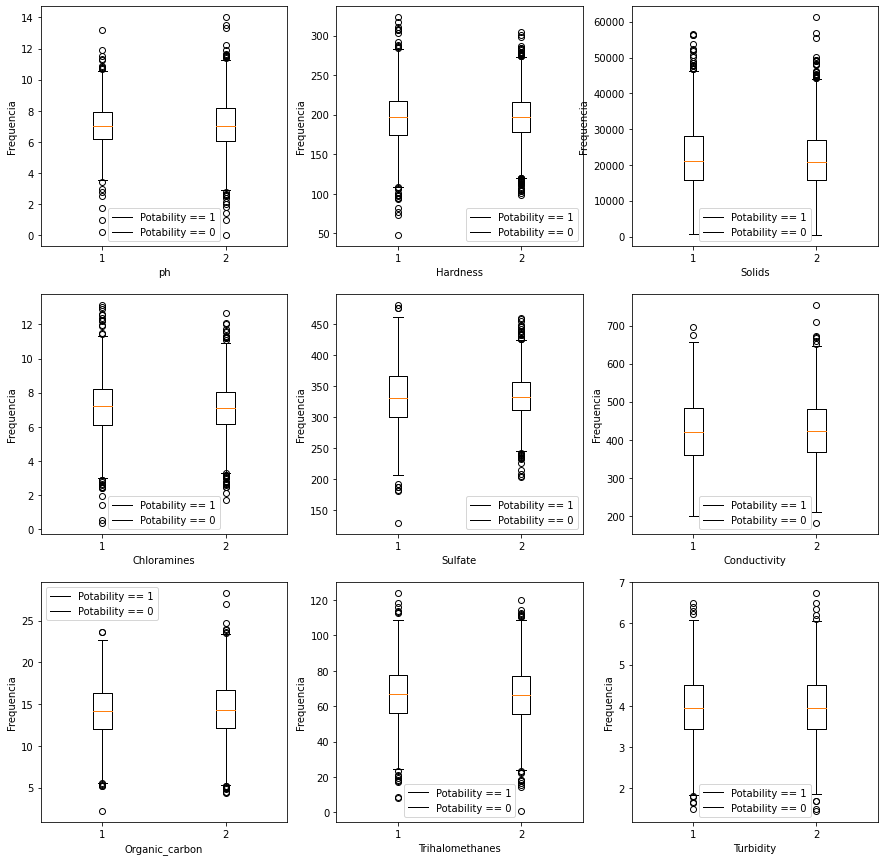

In [98]:
plt.figure(figsize=(15, 15), num='corr_ajustada sem pot')
n = 1
for i in ['ph','Hardness','Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity']:
    plt.subplot(3, 3, n)
    n+=1
    plt.boxplot([df_agua.loc[df_agua['Potability']==1][i].dropna(), df_agua.loc[df_agua['Potability']==0][i].dropna()])
    plt.xlabel(i)
    plt.ylabel('Frequencia')
    plt.legend(('Potability == 1', 'Potability == 0'))
plt.show()

In [99]:
Q1 = df_agua.quantile(0.25)
Q3 = df_agua.quantile(0.75)
IQR = Q3 - Q1
Outliers = ((df_agua < (Q1 - 1.5 * IQR)) | (df_agua > (Q3 + 1.5 * IQR))).sum()
Outliers.sum()

366

In [100]:
df_agua1 = df_agua.copy()
df_agua1_1 = df_agua1.loc[df_agua1['Potability'] == 1]
df_agua1_0 = df_agua1.loc[df_agua1['Potability'] == 0]
for i in list(df_agua):
    df_agua1.loc[df_agua1[i] == 1] = df_agua1.loc[df_agua1[i] == 1].fillna(df_agua1.loc[df_agua1[i] == 1].mean())
    df_agua1.loc[df_agua1[i] == 0] = df_agua1.loc[df_agua1[i] == 0].fillna(df_agua1.loc[df_agua1[i] == 0].mean())
df_agua1

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.085378,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,334.564290,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,334.564290,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,332.566990,392.449580,19.903225,66.539684,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,332.566990,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,332.566990,402.883113,11.168946,77.488213,4.708658,1


In [101]:
df_agua1_Sout = df_agua1.copy()
for i in list(df_agua.columns)[:-1]:
    df_agua1_Sout = df_agua1_Sout[(df_agua1_Sout[i] >= (Q1[i] - 1.5 * IQR[i])) & (df_agua1_Sout[i] <= (Q3[i] + 1.5 * IQR[i]))]
df_agua1_Sout

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.085378,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,334.564290,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,334.564290,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3270,6.069616,186.659040,26138.780191,7.747547,345.700257,415.886955,12.067620,60.419921,3.669712,1
3272,7.808856,193.553212,17329.802160,8.061362,332.566990,392.449580,19.903225,66.539684,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,332.566990,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,332.566990,402.883113,11.168946,77.488213,4.708658,1


In [102]:
# verificando se faltam dados
df_agua1.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [103]:
corr_ajustada = pd.DataFrame.from_dict({k: {i: df_agua1[k].corr(df_agua1[i]) for i in list(df_agua1)} for k in list(df_agua1)})
corr_ajustada

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.075878,-0.081887,-0.031827,0.014785,0.017205,0.040092,0.003009,-0.036211,-0.003848
Hardness,0.075878,1.000000,-0.046899,-0.030054,-0.092718,-0.023915,0.003610,-0.012718,-0.014449,-0.013837
Solids,-0.081887,-0.046899,1.000000,-0.070148,-0.149809,0.013831,0.010242,-0.008849,0.019546,0.033743
Chloramines,-0.031827,-0.030054,-0.070148,1.000000,0.023490,-0.020486,-0.012653,0.016615,0.002363,0.023779
Sulfate,0.014785,-0.092718,-0.149809,0.023490,1.000000,-0.014196,0.027403,-0.025797,-0.009523,-0.026957
Conductivity,0.017205,-0.023915,0.013831,-0.020486,-0.014196,1.000000,0.020966,0.001238,0.005798,-0.008128
Organic_carbon,0.040092,0.003610,0.010242,-0.012653,0.027403,0.020966,1.000000,-0.012944,-0.027308,-0.030001
Trihalomethanes,0.003009,-0.012718,-0.008849,0.016615,-0.025797,0.001238,-0.012944,1.000000,-0.021540,0.007305
Turbidity,-0.036211,-0.014449,0.019546,0.002363,-0.009523,0.005798,-0.027308,-0.021540,1.000000,0.001581
Potability,-0.003848,-0.013837,0.033743,0.023779,-0.026957,-0.008128,-0.030001,0.007305,0.001581,1.000000


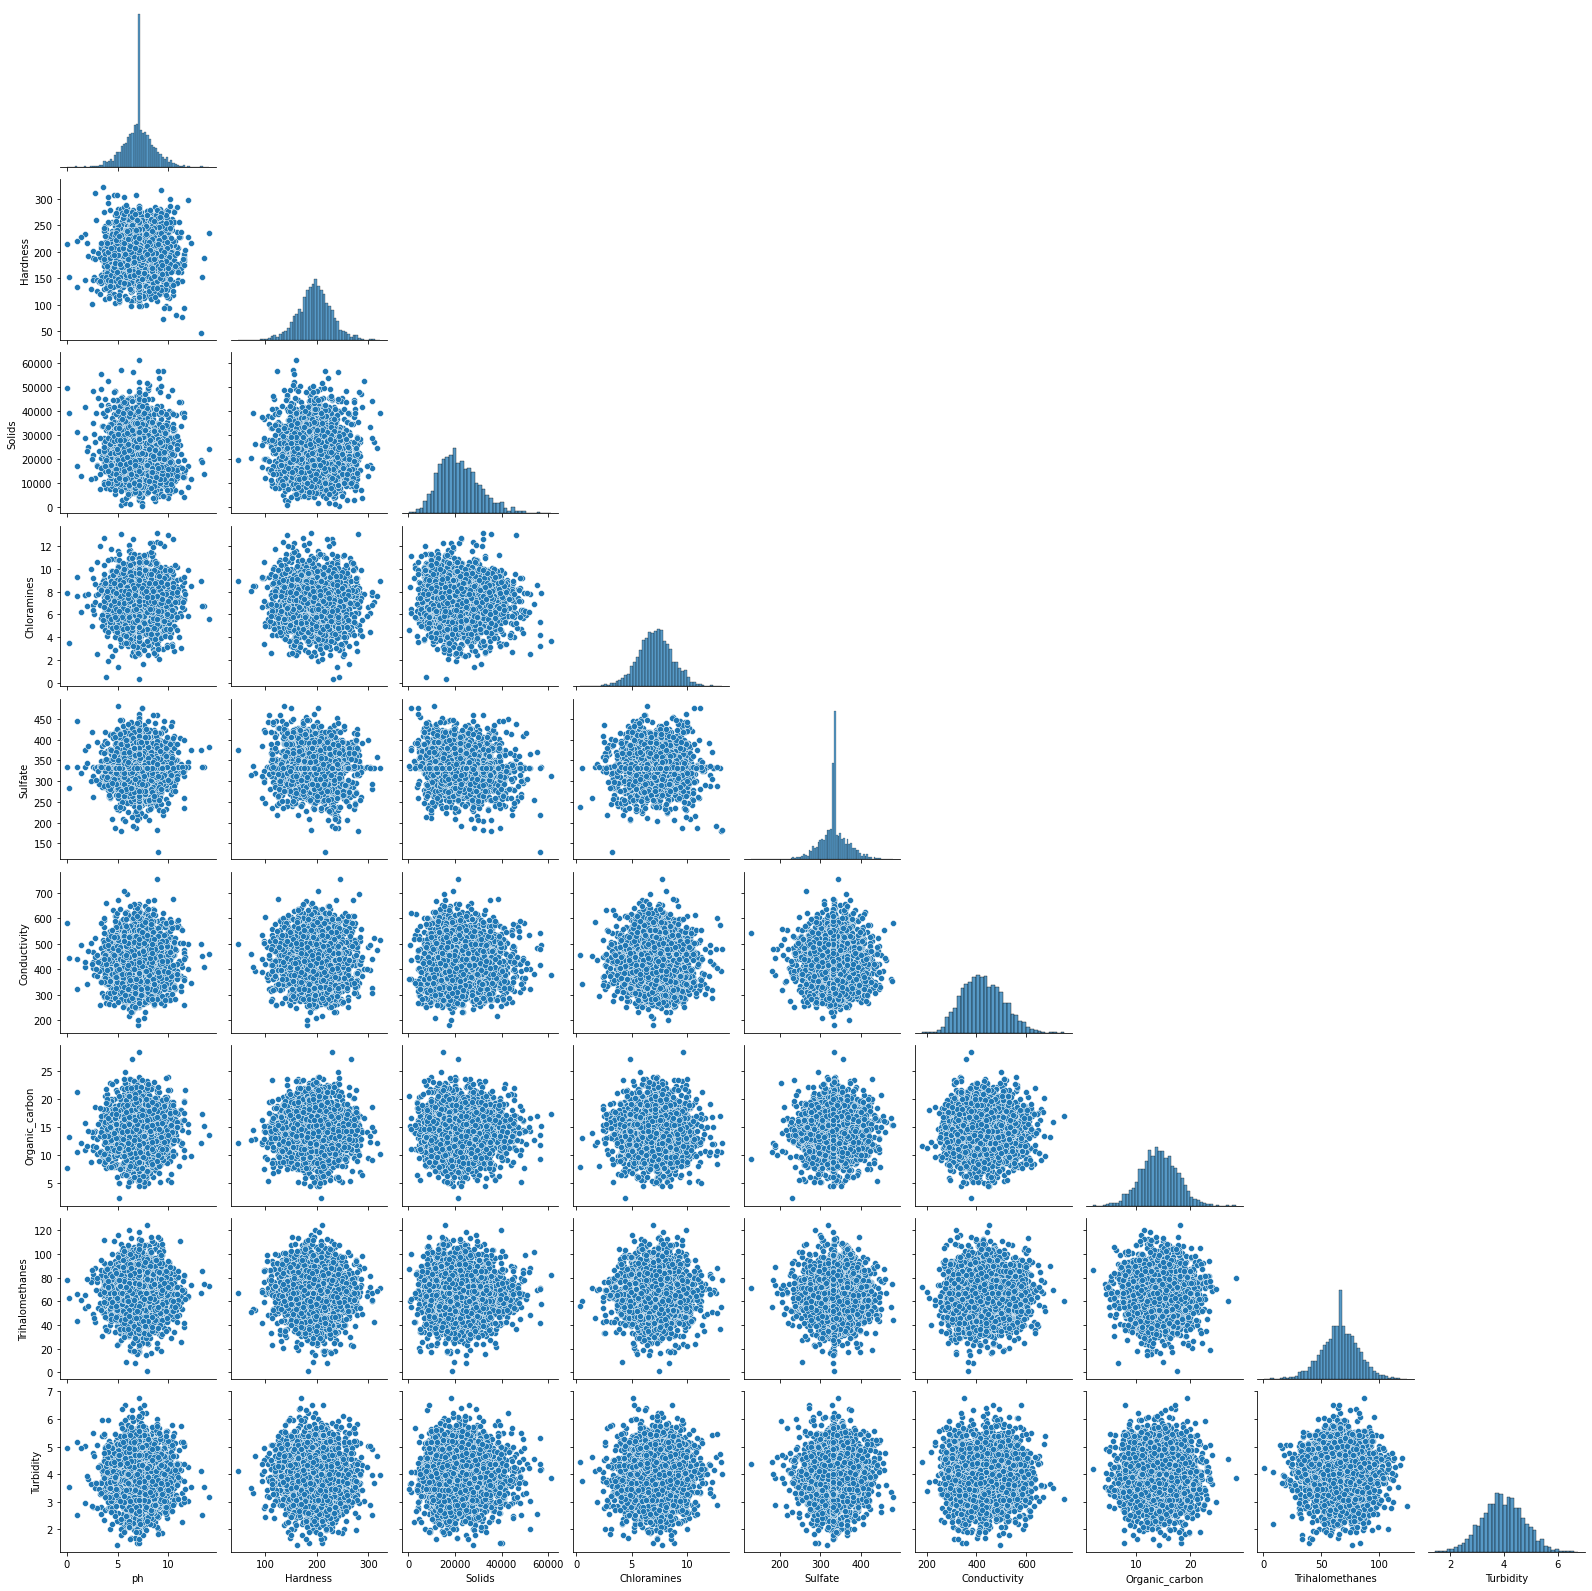

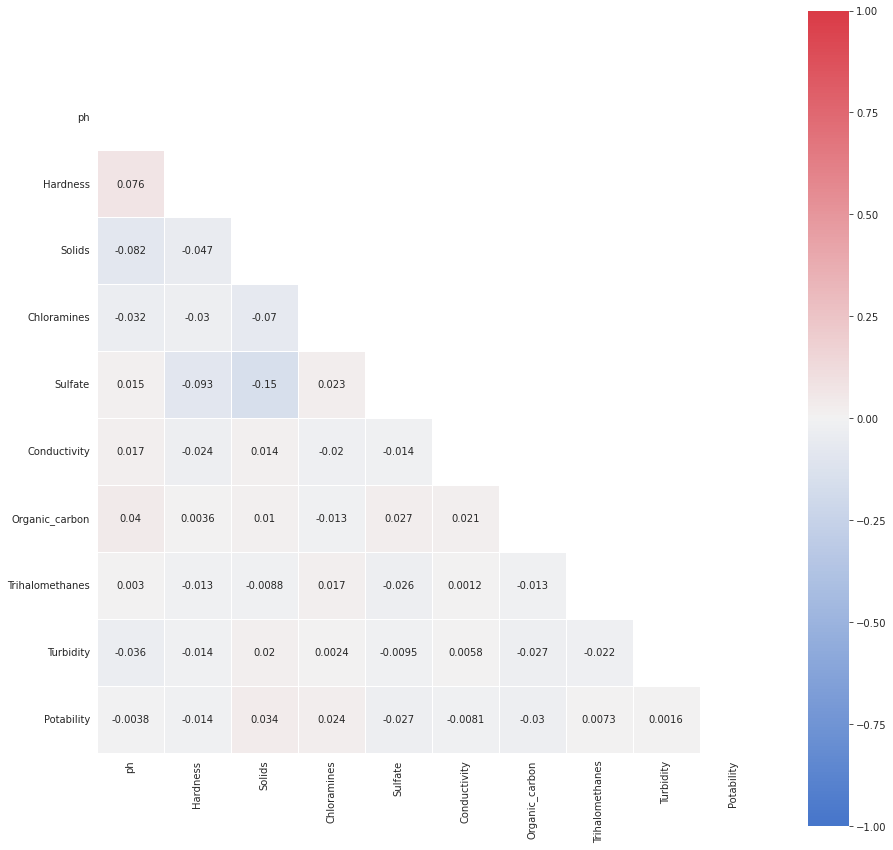

In [104]:
sns.pairplot(df_agua1[['ph','Hardness','Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity']], corner=True)
plt.show(block=False)
mask = np.zeros_like(corr_ajustada)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15), num='corr_ajustada sem pot')
    cmap = sns.diverging_palette(255, 10, as_cmap=True)
    sns.heatmap(corr_ajustada, vmin=-1, vmax=1, mask=mask, cmap=cmap, annot=True, square=True, linewidths=1)
plt.show(block=False)

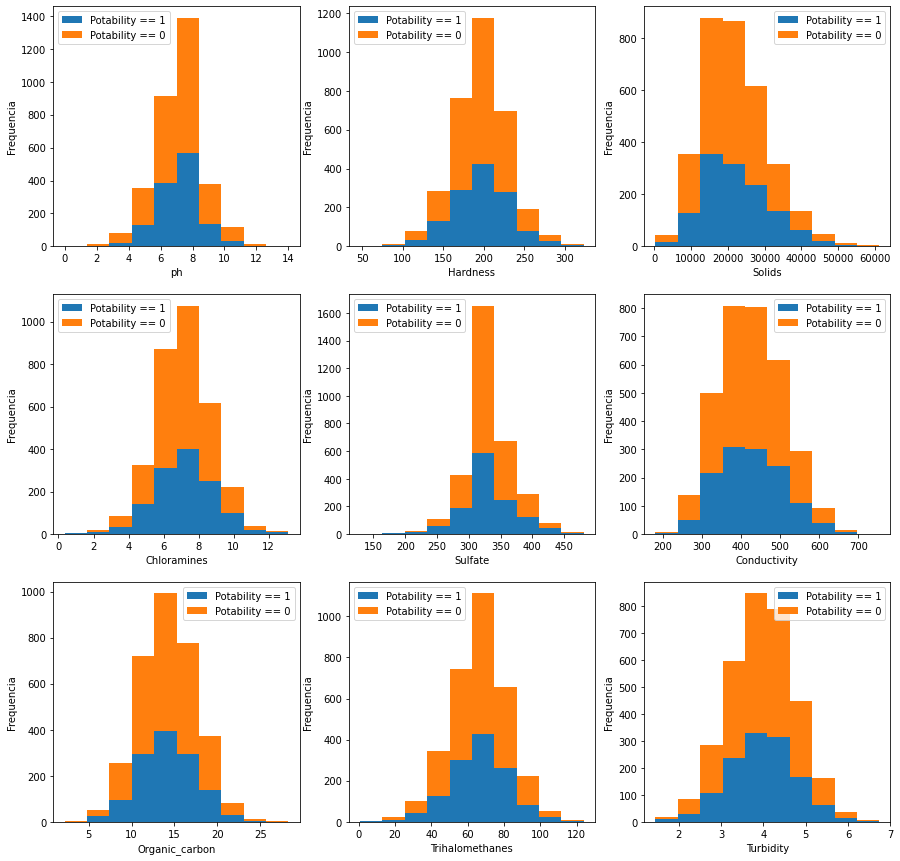

In [105]:
plt.figure(figsize=(15, 15), num='corr_ajustada sem pot')
n = 1
for i in ['ph','Hardness','Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity']:
    plt.subplot(3, 3, n)
    n+=1
    plt.hist([df_agua1.loc[df_agua1['Potability']==1][i], df_agua1.loc[df_agua1['Potability']==0][i]], stacked=True)
    plt.xlabel(i)
    plt.ylabel('Frequencia')
    plt.legend(('Potability == 1', 'Potability == 0'))
plt.show()

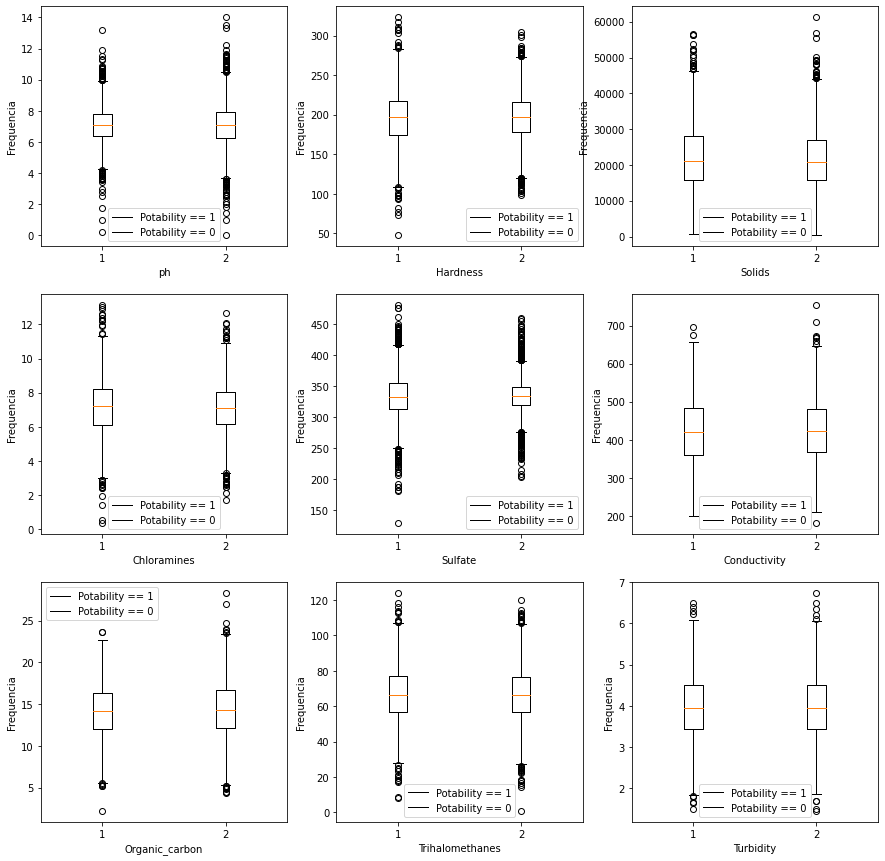

In [106]:
plt.figure(figsize=(15, 15), num='corr_ajustada sem pot')
n = 1
for i in ['ph','Hardness','Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity']:
    plt.subplot(3, 3, n)
    n+=1
    plt.boxplot([df_agua1.loc[df_agua1['Potability']==1][i], df_agua1.loc[df_agua1['Potability']==0][i]])
    plt.xlabel(i)
    plt.ylabel('Frequencia')
    plt.legend(('Potability == 1', 'Potability == 0'))
plt.show()

In [107]:
df_agua1.loc[df_agua1['Potability'] == 1].describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.000000,1278.0
mean,7.073783,195.800744,22383.991018,7.169338,332.566990,425.383800,14.160893,66.539684,3.968328,1.0
std,1.343952,35.547041,9101.010208,1.702988,41.865385,82.048446,3.263907,15.971941,0.780842,0.0
min,0.227499,47.432000,728.750830,0.352000,129.000000,201.619737,2.200000,8.175876,1.492207,1.0
25%,6.351824,174.330531,15668.985035,6.094134,313.052947,360.939023,12.033897,56.911186,3.430909,1.0
50%,7.073783,196.632907,21199.386614,7.215163,332.566990,420.712729,14.162809,66.539684,3.958576,1.0
75%,7.780068,218.003420,27973.236446,8.199261,354.807924,484.155911,16.356245,77.067457,4.509569,1.0
max,13.175402,323.124000,56488.672413,13.127000,481.030642,695.369528,23.604298,124.000000,6.494249,1.0


In [108]:
df_agua1.loc[df_agua1['Potability'] == 0].describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.000000,1998.0
mean,7.085378,196.733292,21777.490788,7.092175,334.564290,426.730454,14.364335,66.303555,3.965800,0.0
std,1.545489,31.057540,8543.068788,1.501045,31.941870,80.047317,3.334554,15.642622,0.780282,0.0
min,0.000000,98.452931,320.942611,1.683993,203.444521,181.483754,4.371899,0.738000,1.450000,0.0
25%,6.224046,177.823265,15663.057382,6.155640,319.354715,368.498530,12.101057,56.441831,3.444062,0.0
50%,7.085378,197.123423,20809.618280,7.090334,334.564290,422.229331,14.293508,66.303555,3.948076,0.0
75%,7.940697,216.120687,27006.249009,8.066462,348.316746,480.677198,16.649485,76.518849,4.496106,0.0
max,14.000000,304.235912,61227.196008,12.653362,460.107069,753.342620,28.300000,120.030077,6.739000,0.0


#  Iniciando modelos de regressão

# Separando a base de dados

In [172]:
# df_agua1_train = df_agua1.sample(frac=0.75)
# df_agua1_test = df_agua1.drop(df_agua1_train.index)
# df_agua1_train_X = df_agua1_train[list(df_agua1_train.columns)[:-1]]
# df_agua1_train_Y = df_agua1_train[list(df_agua1_train.columns)[-1]]
# df_agua1_test_X = df_agua1_test[list(df_agua1_test.columns)[:-1]]
# df_agua1_test_Y = df_agua1_test[list(df_agua1_test.columns)[-1]]
df_agua1_train_X, df_agua1_test_X, df_agua1_train_Y, df_agua1_test_Y = tts(df_agua1.drop(['Potability'], axis=1), df_agua1.Potability, test_size=0.2, random_state=42)
df_agua1_train_X1, df_agua1_test_X1, df_agua1_train_Y1, df_agua1_test_Y1 = tts(df_agua1_Sout.drop(['Potability'], axis=1), df_agua1_Sout.Potability, test_size=0.2, random_state=42)

# Random Forest Classifier

In [173]:
RF_clfC = RandomForestC()
RF_clfS = RandomForestC()
lista_Cout = []; lista_Sout = []; dif = []
for i in range(10):
    RF_clfC.fit(df_agua1_train_X, df_agua1_train_Y)
    a = RF_clfC.score(df_agua1_train_X, df_agua1_train_Y)*100
    b = RF_clfC.score(df_agua1_test_X, df_agua1_test_Y)*100
    c = RF_clfC.predict(df_agua1_test_X)
    RF_clfS.fit(df_agua1_train_X1, df_agua1_train_Y1)
    a1 = RF_clfS.score(df_agua1_train_X1, df_agua1_train_Y1)*100
    b1 = RF_clfS.score(df_agua1_test_X1, df_agua1_test_Y1)*100
    c1 = RF_clfS.predict(df_agua1_test_X1)
    lista_Cout.append(b)
    lista_Sout.append(b1)
    dif.append(b-b1)

In [174]:
display(lista_Cout)
display(lista_Sout)
display(dif)
display(sum(dif))

[81.70731707317073,
 80.33536585365853,
 80.9451219512195,
 80.48780487804879,
 81.40243902439023,
 80.33536585365853,
 81.5548780487805,
 81.25,
 80.9451219512195,
 80.64024390243902]

[78.00338409475465,
 77.834179357022,
 77.834179357022,
 76.98815566835871,
 77.834179357022,
 79.69543147208121,
 78.84940778341793,
 78.00338409475465,
 77.49576988155668,
 76.81895093062606]

[3.703932978416077,
 2.501186496636535,
 3.1109425941975104,
 3.4996492096900766,
 3.5682596673682383,
 0.6399343815773193,
 2.705470265362564,
 3.246615905245349,
 3.4493520696628224,
 3.821292971812966]

30.246636539969458

In [243]:
def my_neural_network(Train_X, Test_X, Train_Y, Test_Y, optimizer='rmsprop', loss=None, metrics=None, loss_weights=None, weighted_metrics=None, run_eagerly=None, steps_per_execution=None, epochs=50, batch_size=1, verbose=1):
    normalizer = StandardScaler().fit(df_agua1_train_X)

    Train_X = normalizer.transform(Train_X)

    Test_X = normalizer.transform(Test_X)

    model = Sequential()

    model.add(Dense(units=128, activation='relu', input_shape=(9,)))

    model.add(Dense(units=128, activation='relu'))

    model.add(Dense(units=128, activation='relu'))

    model.add(Dense(units=128, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics, loss_weights=loss_weights, weighted_metrics=weighted_metrics, run_eagerly=run_eagerly, steps_per_execution=steps_per_execution)

    model.fit(Train_X, Train_Y, epochs=epochs, batch_size=batch_size, verbose=verbose)

    Predict_Y = model.predict(Test_X)
    score = model.evaluate(Test_X, Test_Y,verbose=1, return_dict=True)
    return score

# Com Outliers

In [244]:
my_neural_network(df_agua1_train_X, df_agua1_test_X, df_agua1_train_Y, df_agua1_test_Y, optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])


Epoch 1/50
2620/2620 [==============================] - 2s 633us/step - loss: 0.6562 - accuracy: 0.6275
Epoch 2/50
2620/2620 [==============================] - 2s 599us/step - loss: 0.6227 - accuracy: 0.6637
Epoch 3/50
2620/2620 [==============================] - 2s 642us/step - loss: 0.6097 - accuracy: 0.6805
Epoch 4/50
2620/2620 [==============================] - 1s 563us/step - loss: 0.6038 - accuracy: 0.6844
Epoch 5/50
2620/2620 [==============================] - 2s 587us/step - loss: 0.5950 - accuracy: 0.6870
Epoch 6/50
2620/2620 [==============================] - 2s 578us/step - loss: 0.5860 - accuracy: 0.6935
Epoch 7/50
2620/2620 [==============================] - 2s 589us/step - loss: 0.5752 - accuracy: 0.7004
Epoch 8/50
2620/2620 [==============================] - 2s 607us/step - loss: 0.5626 - accuracy: 0.7046
Epoch 9/50
2620/2620 [==============================] - 2s 648us/step - loss: 0.5457 - accuracy: 0.7153
Epoch 10/50
2620/2620 [==============================] - 2s 610u

{'loss': 3.3122119903564453, 'accuracy': 0.6204268336296082}

# Sem Outliers

In [233]:
my_neural_network(df_agua1_train_X1, df_agua1_test_X1, df_agua1_train_Y1, df_agua1_test_Y1, optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

Epoch 1/50
2360/2360 [==============================] - 2s 622us/step - loss: 0.6523 - accuracy: 0.6373
Epoch 2/50
2360/2360 [==============================] - 1s 576us/step - loss: 0.6257 - accuracy: 0.6610
Epoch 3/50
2360/2360 [==============================] - 1s 605us/step - loss: 0.6029 - accuracy: 0.6797
Epoch 4/50
2360/2360 [==============================] - 1s 572us/step - loss: 0.5966 - accuracy: 0.6881
Epoch 5/50
2360/2360 [==============================] - 1s 622us/step - loss: 0.5919 - accuracy: 0.6839
Epoch 6/50
2360/2360 [==============================] - 1s 594us/step - loss: 0.5821 - accuracy: 0.6894
Epoch 7/50
2360/2360 [==============================] - 1s 580us/step - loss: 0.5675 - accuracy: 0.7013
Epoch 8/50
2360/2360 [==============================] - 1s 574us/step - loss: 0.5549 - accuracy: 0.7165
Epoch 9/50
2360/2360 [==============================] - 1s 593us/step - loss: 0.5463 - accuracy: 0.7242
Epoch 10/50
2360/2360 [==============================] - 1s 620u